In [1]:
pip install -r requirements.txt

  Obtaining dependency information for pandas from https://files.pythonhosted.org/packages/98/af/7be05277859a7bc399da8ba68b88c96b27b48740b6cf49688899c6eb4176/pandas-2.3.3-cp39-cp39-win_amd64.whl.metadata
  Obtaining dependency information for numpy from https://files.pythonhosted.org/packages/ea/2b/7fc9f4e7ae5b507c1a3a21f0f15ed03e794c1242ea8a242ac158beb56034/numpy-2.0.2-cp39-cp39-win_amd64.whl.metadata
  Using cached numpy-2.0.2-cp39-cp39-win_amd64.whl.metadata (59 kB)
  Obtaining dependency information for matplotlib from https://files.pythonhosted.org/packages/57/68/c2feb4667adbf882ffa4b3e0ac9967f848980d9f8b5bebd86644aa67ce6a/matplotlib-3.9.4-cp39-cp39-win_amd64.whl.metadata
  Using cached matplotlib-3.9.4-cp39-cp39-win_amd64.whl.metadata (11 kB)
  Obtaining dependency information for seaborn from https://files.pythonhosted.org/packages/83/11/00d3c3dfc25ad54e731d91449895a79e4bf2384dc3ac01809010ba88f6d5/seaborn-0.13.2-py3-none-any.whl.metadata
  Using cached seaborn-0.13.2-py3-none-an


[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [19]:
!pip install pillow-heif


[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from PIL import Image
from tensorflow.keras import layers, models, callbacks, optimizers
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix


In [5]:
import tensorflow as tf
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # Hilangkan log warning CPU

print(f"TensorFlow Version: {tf.__version__}") # Harus 2.10.x
print(f"Python Version: {sys.version}") # Harus 3.9.x

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"✅ SUKSES! GPU Terdeteksi: {gpus}")
    print("RTX 4060 Anda siap digunakan untuk training.")
else:
    print("❌ GAGAL. Masih menggunakan CPU.")

TensorFlow Version: 2.20.0
Python Version: 3.9.13 (tags/v3.9.13:6de2ca5, May 17 2022, 16:36:42) [MSC v.1929 64 bit (AMD64)]
❌ GAGAL. Masih menggunakan CPU.


In [4]:
import os
from PIL import Image
from tqdm import tqdm
import pandas as pd

# --- KHUSUS HEIC ---
# Daftarkan pembaca HEIC agar Image.open() bisa membacanya
try:
    from pillow_heif import register_heif_opener
    register_heif_opener()
    print("Support HEIC berhasil diaktifkan.")
except ImportError:
    print("Library 'pillow-heif' belum terinstall. Jalankan '!pip install pillow-heif' dulu.")

# ==========================================
# KONVERSI SEMUA DATA (TERMASUK HEIC) KE PNG
# ==========================================

output_base_dir = 'DENGAN LEMPUK PNG 2'  # Folder tujuan
print(f"\nMemulai konversi gambar ke PNG...")
print(f"Data akan disimpan di: {output_base_dir}")

new_data_list = []
error_files = []

# Menggunakan tqdm untuk progress bar
for index, row in tqdm(df.iterrows(), total=df.shape[0], desc="Converting"):
    src_path = row['filepath']
    label = row['label']  
    
    # 1. Persiapan Folder Tujuan
    parts = label.split() 
    variation_folder = parts[0] # V1
    quality_folder = parts[1]   # BAIK
    
    target_folder = os.path.join(output_base_dir, quality_folder, variation_folder)
    os.makedirs(target_folder, exist_ok=True)
    
    # 2. Nama File Baru (.png)
    file_name = os.path.basename(src_path)
    name_without_ext = os.path.splitext(file_name)[0]
    new_filename = f"{name_without_ext}.png"
    dst_path = os.path.join(target_folder, new_filename)
    
    # 3. Proses Konversi
    try:
        # Image.open sekarang sudah bisa buka HEIC karena register_heif_opener()
        with Image.open(src_path) as img:
            
            # Convert ke RGB 
            # (Penting: HEIC/PNG bisa punya alpha channel/transparansi, 
            # untuk deep learning amannya dipaksa ke RGB 3-channel)
            img = img.convert('RGB')
            
            # Simpan sebagai PNG
            img.save(dst_path, 'PNG')
            
            # Masukkan path baru ke list
            new_data_list.append({'filepath': dst_path, 'label': label})
            
    except Exception as e:
        print(f"\n[ERROR] Gagal: {src_path} | Error: {e}")
        error_files.append(src_path)

# ==========================================
# UPDATE DATAFRAME
# ==========================================
df_png = pd.DataFrame(new_data_list)
df = df_png # Timpa df lama dengan data PNG baru

print("\n" + "="*40)
print("KONVERSI SELESAI")
print("="*40)
print(f"Total Asli  : {len(df) + len(error_files)}")
print(f"Berhasil PNG: {len(df_png)}")
print(f"Gagal       : {len(error_files)}")

if len(error_files) > 0:
    print("Contoh file gagal:", error_files[:3])

Support HEIC berhasil diaktifkan.

Memulai konversi gambar ke PNG...
Data akan disimpan di: DENGAN LEMPUK PNG 2


Converting: 100%|██████████| 274/274 [03:30<00:00,  1.30it/s]


KONVERSI SELESAI
Total Asli  : 274
Berhasil PNG: 274
Gagal       : 0


## LOAD DATA

In [5]:
# ==========================================
# 1. MOUNT GOOGLE DRIVE & PERSIAPAN DATA
# ==========================================


# --- KONFIGURASI FOLDER ---
# Pastikan path ini sesuai dengan di Drive Anda
base_dir = 'DENGAN LEMPUK PNG 2'

# List Variasi dan Kualitas sesuai struktur folder Anda
qualities = ['BAIK', "BURUK"]
# qualities = ['BAIK']
variations = ['V1', 'V2', 'V3', 'V4']
print("Sedang memindai file dan membuat label...")

data_list = []

# Loop untuk membaca file dari struktur folder
for quality in qualities:

  for variation in variations:
      # Menyusun path: .../TANPA LEMPUK/BAIK/Variasi 1
      folder_path = os.path.join(base_dir, quality, variation)
        
      if os.path.exists(folder_path):
          files = os.listdir(folder_path)
          for file_name in files:
              if file_name.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.heic')):
                  # Membuat Label: "Variasi 1 BAIK", dst.
                  label_name = f"{variation} {quality}" 
                  full_path = os.path.join(folder_path, file_name)
                  data_list.append({'filepath': full_path, 'label': label_name})
      else:
          print(f"Warning: Folder tidak ditemukan -> {folder_path}")

# Konversi ke DataFrame
df = pd.DataFrame(data_list)
print(f"\nTotal Data Ditemukan: {len(df)}")
print(f"Jumlah Kelas: {df['label'].nunique()}")

# Cek distribusi data
print("\nJumlah data per kelas:")
print(df['label'].value_counts())

Sedang memindai file dan membuat label...

Total Data Ditemukan: 274
Jumlah Kelas: 8

Jumlah data per kelas:
label
V3 BURUK    60
V4 BURUK    54
V1 BURUK    40
V2 BURUK    40
V4 BAIK     20
V3 BAIK     20
V2 BAIK     20
V1 BAIK     20
Name: count, dtype: int64


In [6]:
def visualisasikan_split(train_df, val_df, test_df):
    # ==========================================
    # 1. PIE CHART: Persentase Total
    # ==========================================
    sizes = [len(train_df), len(val_df), len(test_df)]
    labels = ['Training (70%)', 'Validation (20%)', 'Testing (10%)']
    colors = ['#4CAF50', '#FFC107', '#2196F3'] # Hijau, Kuning, Biru
    explode = (0.05, 0, 0)  # Sedikit memisahkan slice Training

    plt.figure(figsize=(18, 6))

    # Subplot 1: Pie Chart
    plt.subplot(1, 2, 1)
    plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', 
            startangle=140, pctdistance=0.85, explode=explode, shadow=True)
    
    # Membuat lingkaran tengah (Donut Chart) agar lebih estetik
    centre_circle = plt.Circle((0,0),0.70,fc='white')
    fig = plt.gcf()
    fig.gca().add_artist(centre_circle)
    
    plt.title('Proporsi Pembagian Data Keseluruhan', fontsize=14, fontweight='bold')
    plt.axis('equal')  

    # ==========================================
    # 2. STACKED BAR CHART: Distribusi Per Kelas
    # ==========================================
    # Menghitung jumlah data per kelas untuk setiap set
    train_counts = train_df['label'].value_counts().sort_index()
    val_counts = val_df['label'].value_counts().sort_index()
    test_counts = test_df['label'].value_counts().sort_index()

    # Membuat DataFrame gabungan untuk plotting
    df_counts = pd.DataFrame({
        'Training': train_counts,
        'Validation': val_counts,
        'Testing': test_counts
    })

    # Subplot 2: Stacked Bar Chart
    plt.subplot(1, 2, 2)
    
    # Plotting
    df_counts.plot(kind='bar', stacked=True, color=colors, ax=plt.gca(), width=0.8)
    
    plt.title('Distribusi Data Per Kelas (Stratified)', fontsize=14, fontweight='bold')
    plt.xlabel('Label Kelas')
    plt.ylabel('Jumlah Gambar')
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Dataset')
    plt.grid(axis='y', linestyle='--', alpha=0.5)

    plt.tight_layout()
    plt.show()
    
    # Menampilkan tabel detail
    print("\nDetail Jumlah Data Per Kelas:")
    print(df_counts)

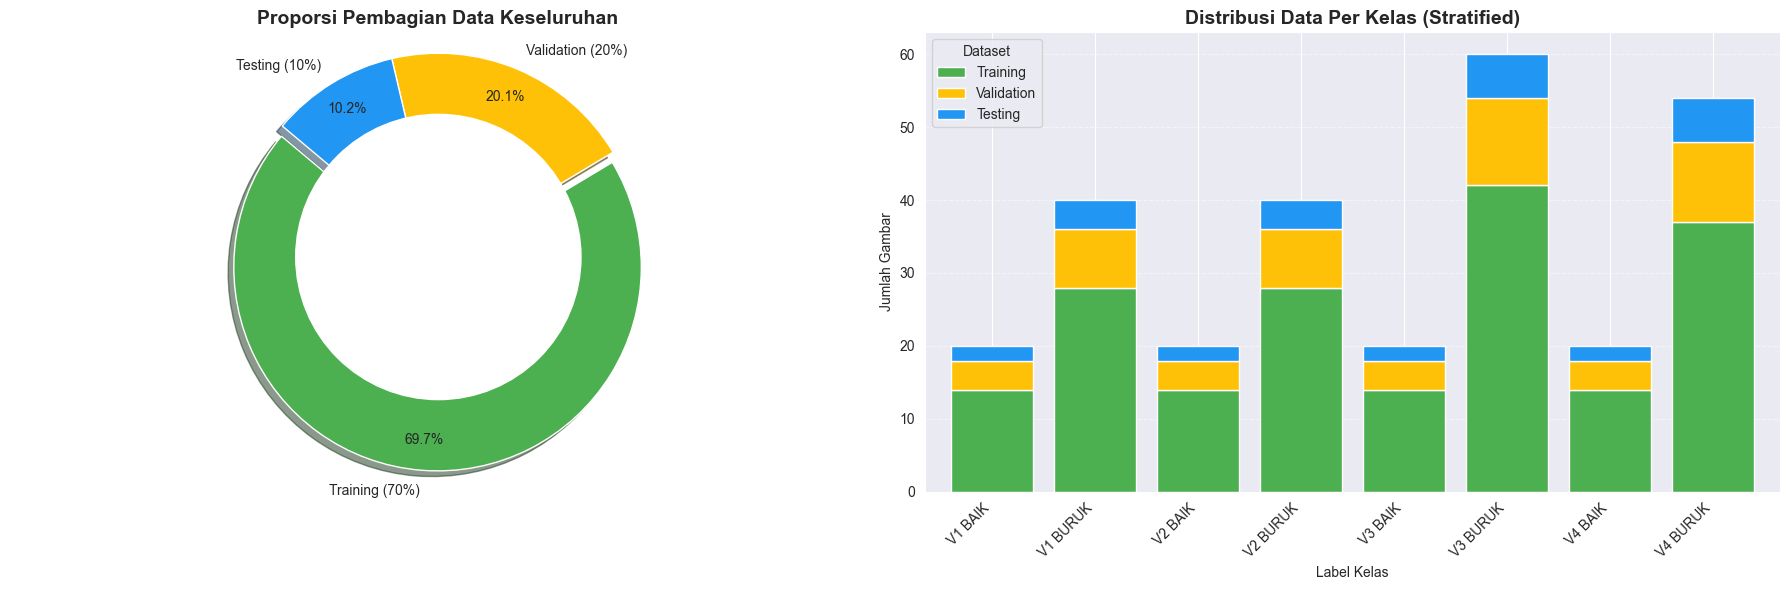


Detail Jumlah Data Per Kelas:
          Training  Validation  Testing
label                                  
V1 BAIK         14           4        2
V1 BURUK        28           8        4
V2 BAIK         14           4        2
V2 BURUK        28           8        4
V3 BAIK         14           4        2
V3 BURUK        42          12        6
V4 BAIK         14           4        2
V4 BURUK        37          11        6

--- Pembagian Data ---
Training   : 191 (69.7%)
Validation : 55 (20.1%)
Test       : 28 (10.2%)


In [7]:
# ==========================================
# 2. SPLITTING DATA (70% Train, 20% Val, 10% Test)
# ==========================================
# Langkah 1: Pisahkan 70% untuk Training
train_df, temp_df = train_test_split(df, train_size=0.7, stratify=df['label'], random_state=42)

# Langkah 2: Pisahkan sisanya (Temp) menjadi Val dan Test
# Val mengambil 2/3 dari Temp (sehingga totalnya 20% dari keseluruhan)
val_df, test_df = train_test_split(temp_df, train_size=2/3, stratify=temp_df['label'], random_state=42)

visualisasikan_split(train_df, val_df, test_df)

print(f"\n--- Pembagian Data ---")
print(f"Training   : {len(train_df)} ({len(train_df)/len(df)*100:.1f}%)")
print(f"Validation : {len(val_df)} ({len(val_df)/len(df)*100:.1f}%)")
print(f"Test       : {len(test_df)} ({len(test_df)/len(df)*100:.1f}%)")

## AUGMENTASI

In [8]:


# ==========================================
# 3. DATA GENERATOR
# ==========================================
IMG_SIZE = (150, 150)
BATCH_SIZE = 32


train_datagen = ImageDataGenerator(
    rescale=1./255,             # Normalisasi pixel
    rotation_range=30,          # Rotasi gambar hingga 30 derajat
    width_shift_range=0.2,      # Geser gambar secara horizontal
    height_shift_range=0.2,     # Geser gambar secara vertikal
    shear_range=0.2,            # Efek miring (shear)
    zoom_range=0.2,             # Zoom in/out
    horizontal_flip=True,       # Membalik gambar horizontal
    fill_mode='nearest'         # Mengisi pixel kosong akibat rotasi
)

val_test_datagen = ImageDataGenerator(rescale=1./255,
                                      horizontal_flip=True)

# Train Generator
train_gen = train_datagen.flow_from_dataframe(
    dataframe=train_df, x_col='filepath', y_col='label',
    target_size=IMG_SIZE, batch_size=BATCH_SIZE,
    class_mode='categorical', shuffle=True
)

# Validation Generator
val_gen = train_datagen.flow_from_dataframe(
    dataframe=val_df, x_col='filepath', y_col='label',
    target_size=IMG_SIZE, batch_size=BATCH_SIZE,
    class_mode='categorical', shuffle=False
)

# Test Generator (Shuffle False agar urutan prediksi sesuai label asli untuk evaluasi)
test_gen = val_test_datagen.flow_from_dataframe(
    dataframe=test_df, x_col='filepath', y_col='label',
    target_size=IMG_SIZE, batch_size=BATCH_SIZE,
    class_mode='categorical', shuffle=False
)

class_names = list(train_gen.class_indices.keys())

Found 191 validated image filenames belonging to 8 classes.
Found 55 validated image filenames belonging to 8 classes.
Found 28 validated image filenames belonging to 8 classes.


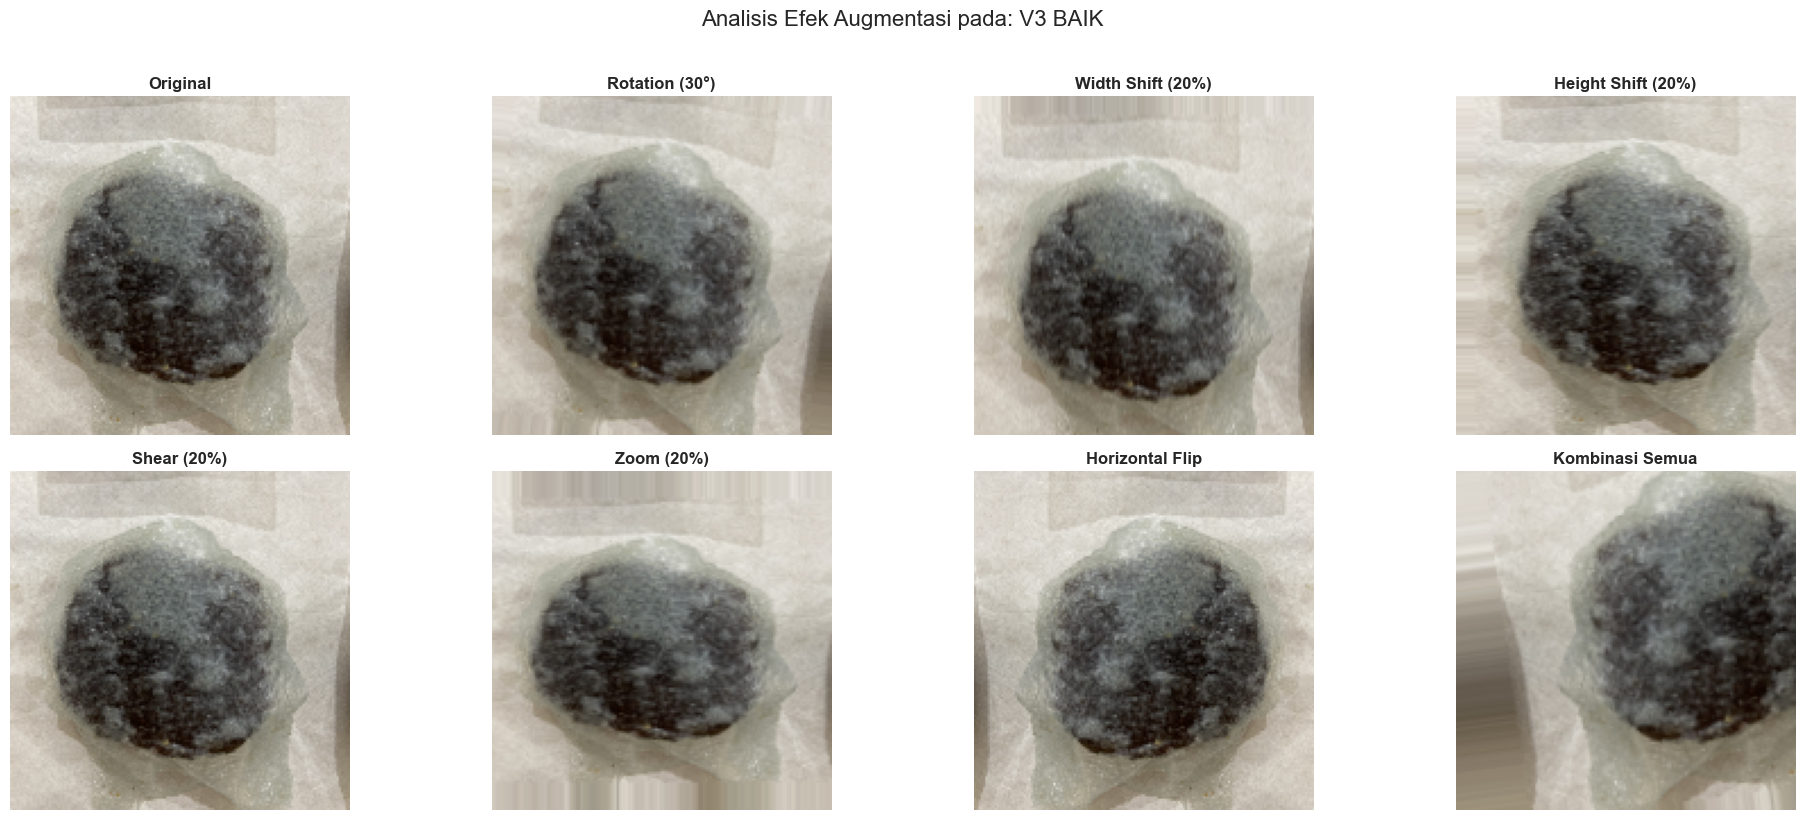

In [9]:
def visualize_specific_augmentations(dataframe):
    # 1. Ambil 1 Gambar Sampel
    sample_row = dataframe.sample(1).iloc[0]
    img_path = sample_row['filepath']
    label = sample_row['label']
    
    # Load dan Preprocess
    img = load_img(img_path, target_size=(150, 150))
    x = img_to_array(img)
    x = x.reshape((1,) + x.shape) # (1, 150, 150, 3)

    # 2. Definisi Parameter Augmentasi Terpisah
    # Kita buat dictionary generator untuk setiap efek
    aug_types = {
        'Original': ImageDataGenerator(rescale=1./255),
        'Rotation (30°)': ImageDataGenerator(rescale=1./255, rotation_range=30, fill_mode='nearest'),
        'Width Shift (20%)': ImageDataGenerator(rescale=1./255, width_shift_range=0.2, fill_mode='nearest'),
        'Height Shift (20%)': ImageDataGenerator(rescale=1./255, height_shift_range=0.2, fill_mode='nearest'),
        'Shear (20%)': ImageDataGenerator(rescale=1./255, shear_range=0.2, fill_mode='nearest'),
        'Zoom (20%)': ImageDataGenerator(rescale=1./255, zoom_range=0.2, fill_mode='nearest'),
        'Horizontal Flip': ImageDataGenerator(rescale=1./255, horizontal_flip=True),
        'Kombinasi Semua': ImageDataGenerator(
            rescale=1./255, rotation_range=30, width_shift_range=0.2,
            height_shift_range=0.2, shear_range=0.2, zoom_range=0.2,
            horizontal_flip=True, fill_mode='nearest'
        )
    }

    # 3. Plotting
    plt.figure(figsize=(20, 8))
    plt.suptitle(f"Analisis Efek Augmentasi pada: {label}", fontsize=16, y=1.02)

    for i, (name, datagen) in enumerate(aug_types.items()):
        # Generate 1 gambar dari flow
        # Seed diset agar randomness-nya bisa kita kontrol sedikit (opsional)
        gen = datagen.flow(x, batch_size=1, seed=42)
        aug_img = next(gen)[0]
        
        plt.subplot(2, 4, i + 1)
        plt.imshow(aug_img)
        plt.title(name, fontsize=12, fontweight='bold')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Jalankan Fungsi
visualize_specific_augmentations(train_df)

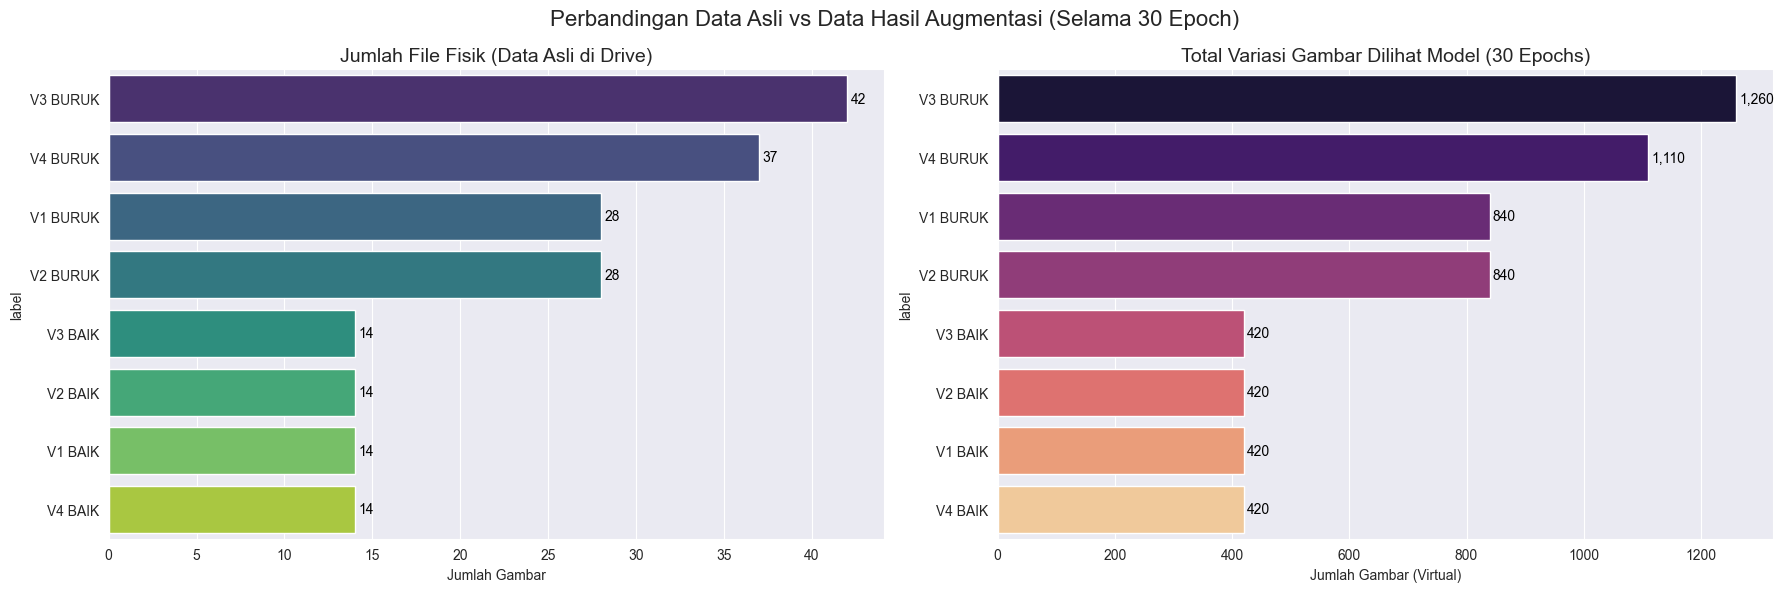


--- PENJELASAN ---
1. Total File Asli Training: 191 gambar.
2. Karena Augmentasi terjadi setiap epoch, dalam 30 epoch model akan belajar dari:
   191 x 30 = 5730 variasi gambar berbeda.
3. Inilah mengapa Augmentasi sangat ampuh mencegah overfitting walaupun data asli sedikit.


In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

def visualize_data_expansion(train_df, epochs=30):
    # Hitung data fisik asli
    original_counts = train_df['label'].value_counts()
    
    # Hitung data virtual (Data Asli x Jumlah Epoch)
    virtual_counts = original_counts * epochs
    
    classes = original_counts.index
    
    # Setup Plot
    fig, ax = plt.subplots(1, 2, figsize=(18, 6))
    
    # Plot 1: Data Fisik (Real)
    # PERBAIKAN: Menambahkan hue=classes dan legend=False
    sns.barplot(x=original_counts.values, y=classes, hue=classes, legend=False, ax=ax[0], palette='viridis')
    
    ax[0].set_title('Jumlah File Fisik (Data Asli di Drive)', fontsize=14)
    ax[0].set_xlabel('Jumlah Gambar')
    for i, v in enumerate(original_counts.values):
        ax[0].text(v + 0.2, i, str(v), color='black', va='center')

    # Plot 2: Data Virtual (Seen by Model)
    # PERBAIKAN: Menambahkan hue=classes dan legend=False
    sns.barplot(x=virtual_counts.values, y=classes, hue=classes, legend=False, ax=ax[1], palette='magma')
    
    ax[1].set_title(f'Total Variasi Gambar Dilihat Model ({epochs} Epochs)', fontsize=14)
    ax[1].set_xlabel('Jumlah Gambar (Virtual)')
    for i, v in enumerate(virtual_counts.values):
        ax[1].text(v + 5, i, f"{v:,}", color='black', va='center') # Format ribuan

    plt.suptitle(f"Perbandingan Data Asli vs Data Hasil Augmentasi (Selama {epochs} Epoch)", fontsize=16)
    plt.tight_layout()
    plt.show()
    
    print(f"\n--- PENJELASAN ---")
    print(f"1. Total File Asli Training: {len(train_df)} gambar.")
    print(f"2. Karena Augmentasi terjadi setiap epoch, dalam {epochs} epoch model akan belajar dari:")
    print(f"   {len(train_df)} x {epochs} = {len(train_df)*epochs} variasi gambar berbeda.")
    print("3. Inilah mengapa Augmentasi sangat ampuh mencegah overfitting walaupun data asli sedikit.")

# Jalankan visualisasi
visualize_data_expansion(train_df, epochs=30)

## TRAINING DATA

In [11]:
# ==========================================
# 4. FUNGSI UTAMA (TRAIN, SAVE, EVALUATE)
# ==========================================
def run_experiment(model, exp_name, epochs=100):
    print(f"\n{'='*15} MULAI: {exp_name} {'='*15}")
    print("Training Device:", tf.test.gpu_device_name() if tf.test.is_gpu_available() else "CPU")
    # 1. Checkpoint: Simpan model terbaik (Best Weights) ke file .keras
    checkpoint_path = f"{exp_name}_best_model.keras"
    checkpoint = callbacks.ModelCheckpoint(
        checkpoint_path, 
        monitor='val_loss', 
        save_best_only=True, 
        mode='min', 
        verbose=1
    )
    
    # 2. Early Stopping: Berhenti jika tidak ada perbaikan
    early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True, verbose=1)
    
    # 3. Reduce LR: Kurangi learning rate jika stagnan
    lr_schedule = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
    
    # 4. CSV Logger
    csv_log = callbacks.CSVLogger(f'{exp_name}_training_log.csv')
    
    # --- TRAINING ---
    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=epochs,
        callbacks=[checkpoint, early_stop, lr_schedule, csv_log],
        verbose=1
    )
    
    # Simpan model versi terakhir (opsional, backup)
    model.save(f"{exp_name}_final_model.keras")
    print(f"Model berhasil disimpan sebagai: {checkpoint_path}")
    
    return history

def evaluate_and_plot(model, history, exp_name):
    # --- PLOT GRAFIK ---
    metrics_df = pd.DataFrame(history.history)
    fig, ax = plt.subplots(1, 2, figsize=(14, 5))
    
    # Grafik Akurasi
    sns.lineplot(data=metrics_df[['accuracy', 'val_accuracy']], ax=ax[0])
    ax[0].set_title(f'{exp_name}: Accuracy')
    
    # Grafik Loss
    sns.lineplot(data=metrics_df[['loss', 'val_loss']], ax=ax[1])
    ax[1].set_title(f'{exp_name}: Loss')
    plt.show()

    # --- EVALUASI TEST SET ---
    print(f"\n--- Evaluasi pada Data Test: {exp_name} ---")
    predictions = model.predict(test_gen)
    y_pred = np.argmax(predictions, axis=1)
    y_true = test_gen.classes

    # Classification Report
    print(classification_report(y_true, y_pred, target_names=class_names))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Prediksi')
    plt.ylabel('Aktual')
    plt.title(f'Confusion Matrix: {exp_name}')
    plt.show()
    
input_shape = (IMG_SIZE[0], IMG_SIZE[1], 3)
num_classes = len(class_names)

In [12]:
from tensorflow.keras.applications import DenseNet121


=============== MULAI: Exp1_DenseNet121_Dengan_Lempuk_2 ===============
Training Device: CPU
Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.3025 - loss: 1.9490

C:\Users\Azvadennys\Desktop\Training Edible Film\venv-39\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1: val_loss improved from inf to 0.80970, saving model to Exp1_DenseNet121_Dengan_Lempuk_2_best_model.keras
6/6 ━━━━━━━━━━━━━━━━━━━━ 41s 7s/step - accuracy: 0.3281 - loss: 1.8792 - val_accuracy: 0.7091 - val_loss: 0.8097 - learning_rate: 0.0010
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8823 - loss: 0.4859
Epoch 2: val_loss improved from 0.80970 to 0.63235, saving model to Exp1_DenseNet121_Dengan_Lempuk_2_best_model.keras
6/6 ━━━━━━━━━━━━━━━━━━━━ 29s 5s/step - accuracy: 0.8842 - loss: 0.4772 - val_accuracy: 0.7455 - val_loss: 0.6323 - learning_rate: 0.0010
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9378 - loss: 0.2153
Epoch 3: val_loss improved from 0.63235 to 0.33114, saving model to Exp1_DenseNet121_Dengan_Lempuk_2_best_model.keras
6/6 ━━━━━━━━━━━━━━━━━━━━ 29s 5s/step - accuracy: 0.9422 - loss: 0.2073 - val_accuracy: 0.8545 - val_loss: 0.3311 - learning_rate: 0.0010
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9918 - loss:

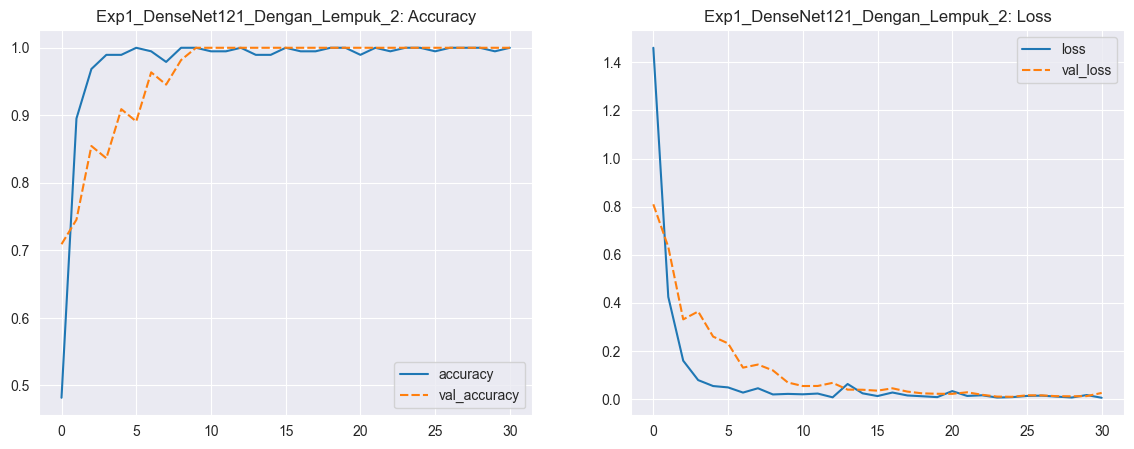


--- Evaluasi pada Data Test: Exp1_DenseNet121_Dengan_Lempuk_2 ---


C:\Users\Azvadennys\Desktop\Training Edible Film\venv-39\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
              precision    recall  f1-score   support

     V1 BAIK       1.00      1.00      1.00         2
    V1 BURUK       1.00      1.00      1.00         4
     V2 BAIK       1.00      1.00      1.00         2
    V2 BURUK       1.00      1.00      1.00         4
     V3 BAIK       1.00      1.00      1.00         2
    V3 BURUK       1.00      1.00      1.00         6
     V4 BAIK       1.00      1.00      1.00         2
    V4 BURUK       1.00      1.00      1.00         6

    accuracy                           1.00        28
   macro avg       1.00      1.00      1.00        28
weighted avg       1.00      1.00      1.00        28



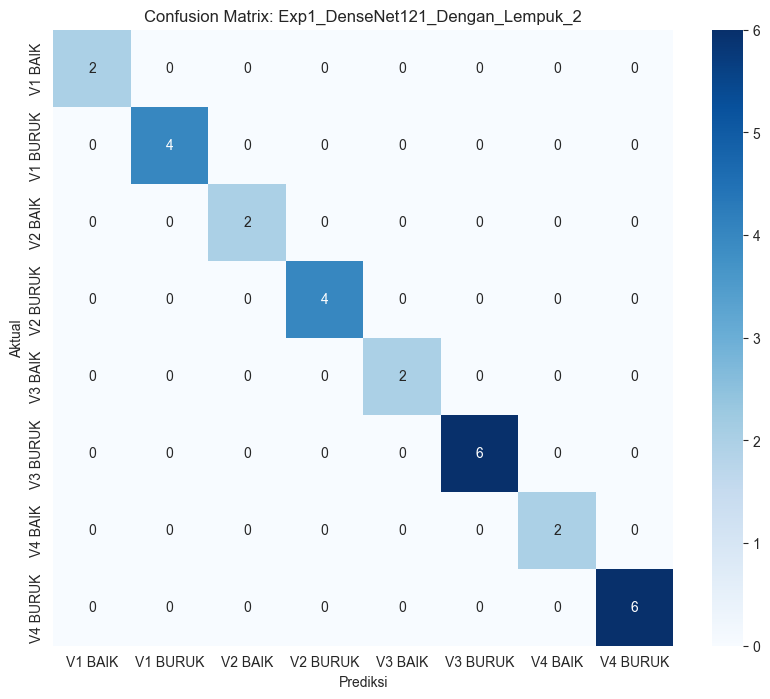

In [14]:

def create_densenet():
    # Load Pre-trained (tanpa bagian atas/head)
    base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape)
    
    # Freeze bobot awal (Feature Extraction)
    base_model.trainable = False

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.BatchNormalization(), # Menstabilkan training
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.4),         # Mencegah overfitting agresif
        layers.Dense(num_classes, activation='softmax')
    ])
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Eksekusi Exp 4
model_4 = create_densenet()
hist_4 = run_experiment(model_4, "Exp1_DenseNet121_Dengan_Lempuk_2", epochs=100)
evaluate_and_plot(model_4, hist_4, "Exp1_DenseNet121_Dengan_Lempuk_2")